In [1]:
# Solving Boltzmann Equations for Dark Matter Relic Abundance

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.special import kn

# Constants
G_N = 6.67430e-11  # Gravitational constant in m^3 kg^-1 s^-2
c = 2.99792458e8   # Speed of light in m/s
hbar = 1.054571817e-34  # Reduced Planck constant in J⋅s
k_B = 1.380649e-23  # Boltzmann constant in J/K
M_Pl = np.sqrt(hbar * c / (8 * np.pi * G_N))  # Reduced Planck mass in kg
H_0 = 67.8*(1/3.086e19)
G_eV_2 = 6.7*1e-39
g_x = 2

# Convert to natural units (GeV)
M_Pl_GeV = M_Pl * c**2 / 1.602176634e-10

# Function to calculate g_*(T)
def g_star(T):
    # Convert input to numpy array if it's not already
    T = np.asarray(T)
    
    # Initialize output array with the same shape as input
    result = np.empty_like(T)
    
    # Apply conditions using numpy's where function
    result = np.where(T > 175, 106.75,
                      np.where(T > 200e-3, 80, 10.75))
    
    return result

In [2]:
def n_eq(x, m_DM=100, g_x=2):
    return (g_x * (m_DM**3) * kn(2, x)) / (2 * (np.pi**2) * x)
    #return g_x * ((m_DM**2/(2*np.pi*x))**(3/2)) * np.exp(-x)

def s(x, m_DM):
    return (2 * (np.pi**2) / 45) * g_star(m_DM/ x) * ((m_DM/x)**3)  # Entropy density

# Boltzmann equation
def boltzmann_eq_W(u, W, sigma_v, m_DM):
    # Y is n/s, x is m/T
    x = np.exp(u)

    T = m_DM/x
    n_eq_u = n_eq(x, m_DM) # Equilibrium number density
    s_u = s(x, m_DM)  # Entropy density
    if n_eq_u == 0:
        W_eq_u = -np.inf
    else:
        W_eq_u = np.log(n_eq_u/s_u)

    lam = (2.76e35)*sigma_v*m_DM

    dWdu = np.exp(-u)*lam*np.sqrt(g_star(T)) * (np.exp(2*W_eq_u-W) - np.exp(W))

    return dWdu

from scipy.integrate import solve_ivp, ode

# Function to solve Boltzmann equation
def solve_boltzmann_W(u, m_DM, sigma_v, W_0):
    sol = solve_ivp(boltzmann_eq_W, [u[0], u[-1]], [W_0], args=(sigma_v, m_DM), method='Radau')
    
    y = sol.y
    t = sol.t
    # Calculate Omega_DM
    rho_c = 3 * H_0**2 / (8 * np.pi * G_eV_2)  # Critical density
    s_0 = 2891.2  # Current entropy density in cm^-3
    Omega_DM = m_DM * y[-1] * s_0 / rho_c
    
    return t, y, Omega_DM

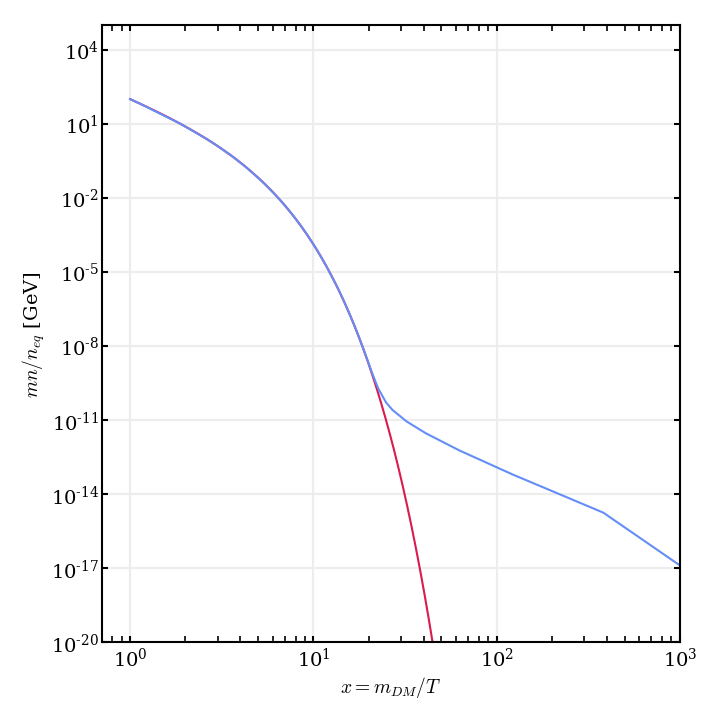

In [ ]:
styles = [r'figure_formatting/styles/aps.mplstyle']
from figure_formatting.plotting_utils import *


with plt.style.context(styles):
    fig = figure(ratio=1)
    ax = add_subplot(fig, 1, 1, 0, 1, 0, 1, ylabellen=40.3/2)
    set_ylim(ax, 1e-20, 1e5, log=True, eps=0)
    set_xlim(ax, 0.7, 1e3, log=True, eps=0)
    ax.set_xlabel(r'$x = m_{DM} / T$')
    ax.set_ylabel(r'$mn /n_{eq}$ [GeV]')
    ax.grid()

    m_DM=100
    u = np.linspace(0, np.log(1e3), 1000)  # From x=1 to x=100
    x = np.exp(u)

    n_eq_0 = n_eq(x[0], m_DM=m_DM)
    n_eq_p = n_eq(x, m_DM=m_DM)
    ax.plot(x, m_DM*(n_eq_p/n_eq_0))

    for sigma_v in [2e-26]:
        m_DM = 100
        n_eq_0 = n_eq(x[0], m_DM)
        s_0 = s(x[0], m_DM)
        W_0 = np.log(n_eq_0/s_0)
    
        u_sol, W, Omega_DM = solve_boltzmann_W(u, m_DM, sigma_v, W_0)
        x_sol = np.exp(u_sol)
        s_p = s(x_sol, m_DM)

        ax.plot(x_sol, m_DM*np.exp(np.ravel(W))*s_p/n_eq_0)


In [4]:
x

array([   1.        ,    1.00069108,    1.00138264, ...,  998.61926487,
        999.30939397, 1000.        ])

In [5]:
x_sol

array([   1.        ,    1.00010001,    1.00110061,    1.01116183,
          1.11750665,    1.84245699,    2.60340892,    2.68528437,
          2.76973475,    3.04436244,    3.66848869,    4.30664586,
          5.41547986,    6.07275608,    6.80980585,    7.25415633,
          7.86450987,    8.36627856,    8.75304194,    9.15768495,
          9.4684134 ,   10.07214017,   10.85411229,   11.7307926 ,
         13.25306599,   14.01581571,   14.23135426,   14.45020742,
         14.99637528,   15.47041661,   15.90029572,   16.17655615,
         16.45761648,   17.15986034,   17.86105117,   18.73451833,
         19.5209038 ,   20.98570675,   22.59581473,   24.91107479,
         26.99670005,   32.26847904,   41.0854165 ,   62.74005408,
        122.21803297,  381.95269185, 1000.        ])

In [6]:
u_sol

array([0.00000000e+00, 1.00000000e-04, 1.10000000e-03, 1.11000000e-02,
       1.11100000e-01, 6.11100000e-01, 9.56821709e-01, 9.87786632e-01,
       1.01875156e+00, 1.11329150e+00, 1.29977978e+00, 1.46015938e+00,
       1.68926149e+00, 1.80381255e+00, 1.91836361e+00, 1.98157459e+00,
       2.06236022e+00, 2.12420917e+00, 2.16940129e+00, 2.21459341e+00,
       2.24796135e+00, 2.30977321e+00, 2.38454402e+00, 2.46221723e+00,
       2.58422892e+00, 2.64018639e+00, 2.65544758e+00, 2.67070877e+00,
       2.70780852e+00, 2.73892959e+00, 2.76633771e+00, 2.78356304e+00,
       2.80078838e+00, 2.84257296e+00, 2.88262243e+00, 2.93036772e+00,
       2.97148588e+00, 3.04384158e+00, 3.11776470e+00, 3.21531248e+00,
       3.29571464e+00, 3.47409087e+00, 3.71565323e+00, 4.13900006e+00,
       4.80580661e+00, 5.94529676e+00, 6.90775528e+00])